In [1]:
# Define helper function for metrics calculation
def metrics_at_threshold(y_true, y_score, thr=0.5):
    y_pred = (y_score >= thr).astype(int)
    cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    return {'threshold': thr, 'precision': prec, 'recall': rec, 'f1': f1, 'cm': cm}

In [10]:
# Debug: Check for NaN values in input data (only if variables exist)
print("Checking for issues with input data...")

# Check if variables exist before using them
if 'X_train' in globals():
    print(f"X_train shape: {X_train.shape}")
    print(f"X_train contains NaN: {np.isnan(X_train).any()}")
    print(f"X_train contains inf: {np.isinf(X_train).any()}")
    print(f"X_train min: {np.nanmin(X_train)}")
    print(f"X_train max: {np.nanmax(X_train)}")
else:
    print("X_train not yet defined")

if 'y_train' in globals():
    print(f"\ny_train shape: {y_train.shape}")
    print(f"y_train value counts: {np.bincount(y_train.astype(int))}")
    print(f"y_train contains NaN: {np.isnan(y_train).any()}")
else:
    print("y_train not yet defined")

# Check the numeric features dataframe if it exists
if 'numeric_features' in globals():
    print(f"\nNumeric features dataframe info:")
    print(f"Contains NaN: {numeric_features.isna().any().any()}")
    print(f"Contains inf: {np.isinf(numeric_features.select_dtypes(include=[np.number])).any().any()}")
    
    # Show which columns have NaN values
    nan_cols = numeric_features.columns[numeric_features.isna().any()].tolist()
    print(f"Columns with NaN: {nan_cols}")

    if nan_cols:
        for col in nan_cols:
            nan_count = numeric_features[col].isna().sum()
            print(f"  {col}: {nan_count} NaN values")
            
    # If there are NaN values, let's fill them
    if numeric_features.isna().any().any():
        print("\nFilling NaN values with forward fill then backward fill...")
        numeric_features_clean = numeric_features.fillna(method='ffill').fillna(method='bfill')
        print(f"After cleaning, contains NaN: {numeric_features_clean.isna().any().any()}")
    else:
        numeric_features_clean = numeric_features
else:
    print("numeric_features not yet defined")

Checking for issues with input data...
X_train shape: (860, 14, 16)
X_train contains NaN: False
X_train contains inf: False
X_train min: -1.8132891654968262
X_train max: 5.9200005531311035

y_train shape: (860,)
y_train value counts: [437 423]
y_train contains NaN: False
numeric_features not yet defined


# COVID-19 ICU Prediction: A Deep Learning Exploration

This comprehensive notebook explores **neural networks and deep learning techniques** to analyze and predict COVID-19 health outcomes, particularly ICU admission requirements. 

## 🧠 Deep Learning Concepts Demonstrated:

### **Core Techniques:**
- **Logistic Regression** (baseline linear classifier)
- **Backpropagation** (gradient-based learning)
- **Convolutional Neural Networks (CNNs)** for feature extraction
- **Recurrent Neural Networks (RNNs)** for sequence modeling
- **Long Short-Term Memory (LSTM)** networks for temporal dependencies

### **Evaluation & Analysis:**
- **Confusion Matrix** analysis
- **Recall and Precision** optimization
- **Softmax activation** for multi-class scenarios
- **Cross-entropy loss** functions
- **ROC/PR curves** for model assessment

### **Implementation:**
- All models implemented in **TensorFlow/Keras**
- Comparative analysis across different architectures
- Hyperparameter tuning and optimization
- Model interpretation and visualization

**Dataset:** OWID COVID-19 time-series data with ICU admission predictions

## 1) Setup & Imports

In [2]:
# Core
import os, json, math, gc, warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (confusion_matrix, precision_score, recall_score, f1_score,
                             roc_auc_score, RocCurveDisplay, PrecisionRecallDisplay,
                             average_precision_score)
from sklearn.utils.class_weight import compute_class_weight

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks, optimizers, losses, models

# Repro
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)

plt.rcParams['figure.figsize'] = (7, 5)


## 2) Configuration

In [3]:
# Attempt to auto-resolve CSV path (supports '(2)' name)
CANDIDATES = ['owid_covid_data_us_subset.csv']
DATA_PATH = None
for c in CANDIDATES:
    if os.path.exists(c):
        DATA_PATH = c
        break
if DATA_PATH is None:
    for c in CANDIDATES:
        p = os.path.join('/mnt/data', c)
        if os.path.exists(p):
            DATA_PATH = p
            break

if DATA_PATH is None:
    raise FileNotFoundError('Dataset not found. Upload the CSV or set DATA_PATH manually.')

# --- Columns ---
TARGET_COL = 'icu_patients'  # changed from 'icu' to 'icu_patients' to match dataset
DATE_COL   = None        # will auto-detect common date column names if None
GROUP_COL  = None        # panel key (e.g., 'location' or 'state'); will try to infer

# --- Sequence params ---
LOOKBACK   = 14          # days in each input sequence
HORIZON    = 1           # predict t+1 ICU
MIN_SEQ    = LOOKBACK + HORIZON

# --- Split params (time-aware) ---
TEST_RATIO = 0.2         # last 20% by time = test
VAL_RATIO  = 0.2         # of the remaining train for validation

# --- Training ---
BATCH_SIZE = 128
EPOCHS     = 60
LR         = 1e-3
PATIENCE   = 6

# --- Threshold tuning ---
BETA = 2.0               # prioritize recall
PRECISION_FLOOR = 0.5    # maintain at least this precision while tuning threshold

## 3) Load & Inspect

In [4]:
df = pd.read_csv(DATA_PATH)
print('Loaded:', DATA_PATH, 'Shape:', df.shape)
display(df.head(3))
print('Columns:', list(df.columns))

# Auto-detect DATE_COL
if DATE_COL is None:
    for cand in ['date', 'Date', 'ds', 'timestamp', 'day']:
        if cand in df.columns:
            DATE_COL = cand
            break

# Try to detect GROUP_COL as a common geo key
if GROUP_COL is None:
    for cand in ['location', 'state', 'county', 'iso_code', 'region']:
        if cand in df.columns:
            GROUP_COL = cand
            break
print('DATE_COL:', DATE_COL)
print('GROUP_COL:', GROUP_COL)

if TARGET_COL not in df.columns:
    raise ValueError(f"TARGET_COL={TARGET_COL!r} not in dataset. Available: {list(df.columns)}")

# Instead of binary > 0, let's create a more meaningful target:
# Predict if ICU patients will be above median (creating balanced classes)
median_icu = df[TARGET_COL].median()
print(f'ICU patients median: {median_icu}')
df[TARGET_COL + '_binary'] = (df[TARGET_COL] > median_icu).astype(int)
TARGET_COL = TARGET_COL + '_binary'  # Update to use the new binary column

print(f'Target distribution: {df[TARGET_COL].value_counts().to_dict()}')

# Parse date if present
if DATE_COL is not None:
    df[DATE_COL] = pd.to_datetime(df[DATE_COL])

Loaded: owid_covid_data_us_subset.csv Shape: (1034, 19)


,date,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,total_deaths_per_million,icu_patients,hosp_patients,weekly_hosp_admissions,daily_case_change_rate,daily_death_change_rate,hospitalization_rate,icu_rate,case_fatality_rate,7day_avg_new_cases,7day_avg_new_deaths,hospitalization_need,icu_requirement
0,2020-07-21,3853351.0,60012.0,145801.0,932.0,11390.679,430.994,11458.0,42195.0,30552.0,NaN,NaN,1.095021,0.297352,3.783746,NaN,NaN,High,High
1,2020-07-22,3911870.0,58519.0,146668.0,867.0,11563.663,433.557,12487.0,46107.0,31352.0,1.518652,0.594646,1.178643,0.319208,3.749307,NaN,NaN,High,High
2,2020-07-23,3975206.0,63336.0,147861.0,1193.0,11750.887,437.084,13916.0,47834.0,31679.0,1.619072,0.813402,1.203309,0.350070,3.719581,NaN,NaN,High,High


Columns: ['date', 'total_cases', 'new_cases', 'total_deaths', 'new_deaths', 'total_cases_per_million', 'total_deaths_per_million', 'icu_patients', 'hosp_patients', 'weekly_hosp_admissions', 'daily_case_change_rate', 'daily_death_change_rate', 'hospitalization_rate', 'icu_rate', 'case_fatality_rate', '7day_avg_new_cases', '7day_avg_new_deaths', 'hospitalization_need', 'icu_requirement']
DATE_COL: date
GROUP_COL: None
ICU patients median: 7657.5
Target distribution: {1: 517, 0: 517}


## 4) Choose Features & Clean

In [5]:
# Drop obvious leakage or non-predictive identifiers
drop_like = ['id', 'uuid']
to_drop = [c for c in df.columns if any(k in c.lower() for k in drop_like)]
maybe_drop = [DATE_COL, TARGET_COL, GROUP_COL]
for c in maybe_drop:
    if c in to_drop:
        continue
    to_drop.append(c)

# Keep numeric features only (LSTM expects floats)
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
num_cols = [c for c in num_cols if c != TARGET_COL]

X_all = df[num_cols].copy()
y_all = df[TARGET_COL].copy()

print('Numeric feature count:', len(num_cols))


Numeric feature count: 16


## 5) Time-Aware Split (Train/Val/Test)

In [6]:
# We'll split by time using the global min->max dates.
if DATE_COL is None:
    raise ValueError('Cannot do time-aware split without a date column. Set DATE_COL to continue.')

df_sorted = df.sort_values([DATE_COL] + ([GROUP_COL] if GROUP_COL else []))
dates = df_sorted[DATE_COL].sort_values()

# 🔧 IMPROVED SPLITTING: Ensure balanced classes in all splits
print("🔍 Checking class distribution across time...")
df_sorted = df.sort_values(DATE_COL)

# Check class distribution over time
time_groups = pd.cut(df_sorted[DATE_COL], bins=10, labels=False)
for i in range(10):
    group_mask = time_groups == i
    if group_mask.sum() > 0:
        class_dist = df_sorted.loc[group_mask, TARGET_COL].value_counts()
        print(f"Time period {i}: Class 0: {class_dist.get(0, 0)}, Class 1: {class_dist.get(1, 0)}")

# Strategy: Use stratified time-aware split to maintain class balance
def stratified_time_split(df, date_col, target_col, test_ratio=0.2, val_ratio=0.2):
    """
    Create time-aware splits while maintaining class balance
    """
    df_sorted = df.sort_values(date_col).reset_index(drop=True)
    n_total = len(df_sorted)
    
    # Calculate split indices
    test_size = int(n_total * test_ratio)
    val_size = int(n_total * val_ratio)
    
    # Get the latest data for test (but ensure some class 1 examples)
    test_indices = df_sorted.tail(test_size).index
    
    # Check if test set has both classes
    test_classes = df_sorted.loc[test_indices, target_col].value_counts()
    print(f"Initial test set distribution: {test_classes.to_dict()}")
    
    if len(test_classes) < 2:  # Only one class in test set
        print("⚠️  Test set has only one class. Adjusting split...")
        # Find indices with both classes near the end
        class_1_indices = df_sorted[df_sorted[target_col] == 1].tail(50).index
        class_0_indices = df_sorted[df_sorted[target_col] == 0].tail(50).index
        
        # Mix recent examples from both classes
        mixed_indices = list(class_1_indices) + list(class_0_indices)
        test_indices = mixed_indices[-test_size:]
    
    # Remove test indices from remaining data
    remaining_indices = df_sorted.index.difference(test_indices)
    df_remaining = df_sorted.loc[remaining_indices]
    
    # Split remaining into train/val
    val_indices = df_remaining.tail(val_size).index
    
    # Check validation set balance
    val_classes = df_sorted.loc[val_indices, target_col].value_counts()
    print(f"Initial validation set distribution: {val_classes.to_dict()}")
    
    if len(val_classes) < 2:  # Only one class in validation set
        print("⚠️  Validation set has only one class. Adjusting split...")
        # Get mixed examples for validation too
        remaining_class_1 = df_remaining[df_remaining[target_col] == 1].tail(30).index
        remaining_class_0 = df_remaining[df_remaining[target_col] == 0].tail(30).index
        mixed_val_indices = list(remaining_class_1) + list(remaining_class_0)
        val_indices = mixed_val_indices[-val_size:]
    
    train_indices = df_sorted.index.difference(test_indices).difference(val_indices)
    
    return train_indices, val_indices, test_indices

# Apply improved splitting
train_indices, val_indices, test_indices = stratified_time_split(df, DATE_COL, TARGET_COL, TEST_RATIO, VAL_RATIO)

df_train = df.loc[train_indices].copy()
df_val = df.loc[val_indices].copy()
df_test = df.loc[test_indices].copy()

print(f'\n✅ IMPROVED SPLITS:')
print('Train:', df_train.shape, f"- Class distribution: {df_train[TARGET_COL].value_counts().to_dict()}")
print('Val:', df_val.shape, f"- Class distribution: {df_val[TARGET_COL].value_counts().to_dict()}")
print('Test:', df_test.shape, f"- Class distribution: {df_test[TARGET_COL].value_counts().to_dict()}")

# Verify all sets have both classes
for name, data in [('Train', df_train), ('Validation', df_val), ('Test', df_test)]:
    unique_classes = data[TARGET_COL].nunique()
    if unique_classes < 2:
        print(f"⚠️  WARNING: {name} set still has only {unique_classes} class(es)")
    else:
        print(f"✓ {name} set has both classes")

🔍 Checking class distribution across time...
Time period 0: Class 0: 0, Class 1: 104
Time period 1: Class 0: 0, Class 1: 103
Time period 2: Class 0: 13, Class 1: 90
Time period 3: Class 0: 56, Class 1: 48
Time period 4: Class 0: 0, Class 1: 103
Time period 5: Class 0: 34, Class 1: 69
Time period 6: Class 0: 104, Class 1: 0
Time period 7: Class 0: 103, Class 1: 0
Time period 8: Class 0: 103, Class 1: 0
Time period 9: Class 0: 104, Class 1: 0
Initial test set distribution: {0: 206}
⚠️  Test set has only one class. Adjusting split...
Initial validation set distribution: {0: 206}
⚠️  Validation set has only one class. Adjusting split...

✅ IMPROVED SPLITS:
Train: (874, 20) - Class distribution: {1: 437, 0: 437}
Val: (60, 20) - Class distribution: {1: 30, 0: 30}
Test: (100, 20) - Class distribution: {1: 50, 0: 50}
✓ Train set has both classes
✓ Validation set has both classes
✓ Test set has both classes


## 6) Build Sliding-Window Sequences (Panel-Aware)

In [7]:
def build_sequences_panel(df_part, feature_cols, target_col, lookback, horizon, group_col=None, date_col=None):
    X_seq, y_seq = [], []
    groups = [None] if group_col is None else df_part[group_col].dropna().unique().tolist()
    for g in groups:
        gdf = df_part if g is None else df_part[df_part[group_col] == g]
        if date_col is not None:
            gdf = gdf.sort_values(date_col)
        feat = gdf[feature_cols].values.astype('float32')
        tgt  = gdf[target_col].values.astype('int32')
        n = len(gdf)
        for i in range(lookback, n - horizon + 1):
            X_seq.append(feat[i - lookback:i, :])
            y_seq.append(tgt[i + horizon - 1])
    return np.array(X_seq), np.array(y_seq)

feature_cols = [c for c in num_cols if c in df.columns]
print('Using', len(feature_cols), 'numeric features for sequences.')

# Clean NaN values before scaling
print("Cleaning NaN values in feature columns...")
for col in feature_cols:
    df_train[col] = df_train[col].fillna(method='ffill').fillna(method='bfill').fillna(0)
    df_val[col] = df_val[col].fillna(method='ffill').fillna(method='bfill').fillna(0)
    df_test[col] = df_test[col].fillna(method='ffill').fillna(method='bfill').fillna(0)

# Scale features (fit on train only) — scale per-feature globally for simplicity
scaler = StandardScaler()
if GROUP_COL:
    # Fit scaler on train features only to avoid leakage
    scaler.fit(df_train[feature_cols])
    df_train[feature_cols] = scaler.transform(df_train[feature_cols])
    df_val[feature_cols]   = scaler.transform(df_val[feature_cols])
    df_test[feature_cols]  = scaler.transform(df_test[feature_cols])
else:
    scaler.fit(df_train[feature_cols])
    df_train[feature_cols] = scaler.transform(df_train[feature_cols])
    df_val[feature_cols]   = scaler.transform(df_val[feature_cols])
    df_test[feature_cols]  = scaler.transform(df_test[feature_cols])

X_train, y_train = build_sequences_panel(df_train, feature_cols, TARGET_COL, LOOKBACK, HORIZON, GROUP_COL, DATE_COL)
X_val,   y_val   = build_sequences_panel(df_val,   feature_cols, TARGET_COL, LOOKBACK, HORIZON, GROUP_COL, DATE_COL)
X_test,  y_test  = build_sequences_panel(df_test,  feature_cols, TARGET_COL, LOOKBACK, HORIZON, GROUP_COL, DATE_COL)

print('Sequences -> X_train:', X_train.shape, ' X_val:', X_val.shape, ' X_test:', X_test.shape)

# Final check for NaN values in sequences
print(f"X_train contains NaN: {np.isnan(X_train).any()}")
print(f"X_val contains NaN: {np.isnan(X_val).any()}")
print(f"X_test contains NaN: {np.isnan(X_test).any()}")

# If any NaN values remain, replace them with 0
if np.isnan(X_train).any():
    print("Replacing remaining NaN values with 0...")
    X_train = np.nan_to_num(X_train, nan=0.0)
    X_val = np.nan_to_num(X_val, nan=0.0)
    X_test = np.nan_to_num(X_test, nan=0.0)

Using 16 numeric features for sequences.
Cleaning NaN values in feature columns...
Sequences -> X_train: (860, 14, 16)  X_val: (46, 14, 16)  X_test: (86, 14, 16)
X_train contains NaN: False
X_val contains NaN: False
X_test contains NaN: False


## 7) Class Weights (Handle Imbalance)

In [8]:
classes = np.unique(y_train)
cw = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weight = {int(c): float(w) for c, w in zip(classes, cw)}
print('Class weight:', class_weight)


Class weight: {0: 0.9839816933638444, 1: 1.016548463356974}


## 8) Deep Learning Architecture Comparison

We'll compare multiple neural network architectures to demonstrate different deep learning concepts:

### 8.1) Logistic Regression Baseline

In [10]:
# Logistic Regression using TensorFlow
# Demonstrates: Linear classification, sigmoid activation, cross-entropy loss

def create_logistic_regression(input_dim):
    """
    Simple logistic regression model demonstrating:
    - Linear transformation (Dense layer with no activation)
    - Sigmoid activation for binary classification
    - Cross-entropy loss via BinaryCrossentropy
    """
    model = keras.Sequential([
        layers.Flatten(input_shape=(LOOKBACK, input_dim)),  # Flatten sequences
        layers.Dense(1, activation='sigmoid', name='logistic_output')
    ])
    
    model.compile(
        optimizer=optimizers.Adam(learning_rate=LR),
        loss=losses.BinaryCrossentropy(),  # Cross-entropy loss
        metrics=[
            keras.metrics.Precision(name='precision'),
            keras.metrics.Recall(name='recall'),
            keras.metrics.AUC(name='auc')
        ]
    )
    return model

print("🔹 Building Logistic Regression Baseline...")
logistic_model = create_logistic_regression(X_train.shape[2])
logistic_model.summary()

# Train logistic regression
print("\n🔹 Training Logistic Regression...")
logistic_hist = logistic_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=BATCH_SIZE,
    class_weight=class_weight,
    verbose=0
)

# Evaluate
logistic_val_proba = logistic_model.predict(X_val, verbose=0).ravel()
logistic_metrics = metrics_at_threshold(y_val, logistic_val_proba, 0.5)
print(f"Logistic Regression Results:")
print(f"  Precision: {logistic_metrics['precision']:.3f}")
print(f"  Recall: {logistic_metrics['recall']:.3f}")
print(f"  F1-Score: {logistic_metrics['f1']:.3f}")
print(f"  AUC: {roc_auc_score(y_val, logistic_val_proba):.3f}")

🔹 Building Logistic Regression Baseline...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 224)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ logistic_output (Dense)         │ (None, 1)              │           225 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 225 (900.00 B)

 Trainable params: 225 (900.00 B)

 Non-trainable params: 0 (0.00 B)


🔹 Training Logistic Regression...
Logistic Regression Results:
  Precision: 0.696
  Recall: 1.000
  F1-Score: 0.821
  AUC: 0.823
Logistic Regression Results:
  Precision: 0.696
  Recall: 1.000
  F1-Score: 0.821
  AUC: 0.823


### 8.2) Convolutional Neural Network (CNN)

In [11]:
# CNN for time-series feature extraction
# Demonstrates: Convolution, pooling, feature maps, backpropagation through conv layers

def create_cnn_model(input_shape, use_softmax=False):
    """
    1D CNN for time-series classification demonstrating:
    - 1D Convolution for temporal feature extraction
    - MaxPooling for dimensionality reduction
    - Multiple conv layers with increasing filters
    - Global pooling before classification
    - Optional softmax for multi-class (we'll use for binary too)
    """
    inputs = layers.Input(shape=input_shape)
    
    # First conv block - detect local patterns
    x = layers.Conv1D(32, kernel_size=3, activation='relu', padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.Dropout(0.25)(x)
    
    # Second conv block - detect higher-level patterns
    x = layers.Conv1D(64, kernel_size=3, activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.Dropout(0.25)(x)
    
    # Third conv block - complex feature extraction
    x = layers.Conv1D(128, kernel_size=3, activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.GlobalMaxPooling1D()(x)  # Global pooling to get fixed-size output
    
    # Classification head
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    
    if use_softmax:
        # For demonstration: 2-class softmax (equivalent to sigmoid for binary)
        x = layers.Dense(2, activation='softmax', name='softmax_output')(x)
        loss = losses.SparseCategoricalCrossentropy()
        metrics = ['accuracy']
    else:
        x = layers.Dense(1, activation='sigmoid', name='sigmoid_output')(x)
        loss = losses.BinaryCrossentropy()
        metrics = [keras.metrics.Precision(), keras.metrics.Recall()]
    
    model = keras.Model(inputs, x)
    model.compile(
        optimizer=optimizers.Adam(learning_rate=LR),
        loss=loss,
        metrics=metrics
    )
    return model

print("🔹 Building CNN Model...")
cnn_model = create_cnn_model(X_train.shape[1:])
cnn_model.summary()

# Train CNN
print("\n🔹 Training CNN...")
cnn_hist = cnn_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=40,
    batch_size=BATCH_SIZE,
    class_weight=class_weight,
    callbacks=[callbacks.EarlyStopping(patience=5, restore_best_weights=True)],
    verbose=0
)

# Evaluate CNN
cnn_val_proba = cnn_model.predict(X_val, verbose=0).ravel()
cnn_metrics = metrics_at_threshold(y_val, cnn_val_proba, 0.5)
print(f"CNN Results:")
print(f"  Precision: {cnn_metrics['precision']:.3f}")
print(f"  Recall: {cnn_metrics['recall']:.3f}")
print(f"  F1-Score: {cnn_metrics['f1']:.3f}")
print(f"  AUC: {roc_auc_score(y_val, cnn_val_proba):.3f}")

🔹 Building CNN Model...


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 14, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 14, 32)         │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 14, 32)         │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 7, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 7, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 7, 64)          │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 7, 64)          │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 3, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 3, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 3, 128)         │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 3, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sigmoid_output (Dense)          │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 41,697 (162.88 KB)

 Trainable params: 41,249 (161.13 KB)

 Non-trainable params: 448 (1.75 KB)


🔹 Training CNN...
CNN Results:
  Precision: 1.000
  Recall: 0.938
  F1-Score: 0.968
  AUC: 0.990
CNN Results:
  Precision: 1.000
  Recall: 0.938
  F1-Score: 0.968
  AUC: 0.990


### 8.3) Simple RNN vs LSTM Comparison

In [9]:
# Compare Simple RNN vs LSTM
# Demonstrates: Vanilla RNN limitations, LSTM gates, gradient flow

def create_simple_rnn(input_shape):
    """
    Simple RNN demonstrating:
    - Basic recurrent connections
    - Vanishing gradient problems with long sequences
    - Limited ability to capture long-term dependencies
    """
    inputs = layers.Input(shape=input_shape)
    x = layers.Masking(mask_value=0.0)(inputs)
    x = layers.SimpleRNN(32, return_sequences=True, dropout=0.2)(x)
    x = layers.SimpleRNN(16, dropout=0.2)(x)
    x = layers.Dense(16, activation='relu')(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    
    model = keras.Model(inputs, outputs)
    model.compile(
        optimizer=optimizers.Adam(learning_rate=LR),
        loss=losses.BinaryCrossentropy(),
        metrics=[keras.metrics.Precision(), keras.metrics.Recall()]
    )
    return model

def create_improved_lstm(input_shape):
    """
    Enhanced LSTM demonstrating:
    - Forget, input, and output gates
    - Cell state for long-term memory
    - Better gradient flow through time
    - Simpler architecture to prevent memory issues
    """
    inputs = layers.Input(shape=input_shape)
    x = layers.Masking(mask_value=0.0)(inputs)
    
    # Simplified LSTM - reduced complexity to prevent crashes
    x = layers.LSTM(32, return_sequences=True, dropout=0.2)(x)
    x = layers.LSTM(16, dropout=0.2)(x)
    
    # Simple dense layers
    x = layers.Dense(16, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    
    model = keras.Model(inputs, outputs)
    model.compile(
        optimizer=optimizers.Adam(learning_rate=LR),
        loss=losses.BinaryCrossentropy(),
        metrics=[keras.metrics.Precision(), keras.metrics.Recall()]
    )
    return model

# Build models
print("🔹 Building Simple RNN...")
simple_rnn = create_simple_rnn(X_train.shape[1:])

print("🔹 Building Enhanced LSTM...")
enhanced_lstm = create_improved_lstm(X_train.shape[1:])

# Train both models with reduced complexity
print("\n🔹 Training Simple RNN...")
rnn_hist = simple_rnn.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,  # Reduced epochs
    batch_size=64,  # Smaller batch size
    class_weight=class_weight,
    verbose=0
)

print("🔹 Training Enhanced LSTM...")
lstm_hist = enhanced_lstm.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=25,  # Reduced epochs
    batch_size=64,  # Smaller batch size
    class_weight=class_weight,
    callbacks=[callbacks.EarlyStopping(patience=5, restore_best_weights=True)],
    verbose=0
)

# Compare results
rnn_val_proba = simple_rnn.predict(X_val, verbose=0).ravel()
lstm_val_proba = enhanced_lstm.predict(X_val, verbose=0).ravel()

rnn_metrics = metrics_at_threshold(y_val, rnn_val_proba, 0.5)
lstm_metrics = metrics_at_threshold(y_val, lstm_val_proba, 0.5)

print(f"\n📊 RNN vs LSTM Comparison:")
print(f"Simple RNN  - Precision: {rnn_metrics['precision']:.3f}, Recall: {rnn_metrics['recall']:.3f}, F1: {rnn_metrics['f1']:.3f}")
print(f"Enhanced LSTM - Precision: {lstm_metrics['precision']:.3f}, Recall: {lstm_metrics['recall']:.3f}, F1: {lstm_metrics['f1']:.3f}")

🔹 Building Simple RNN...
🔹 Building Enhanced LSTM...

🔹 Training Simple RNN...
🔹 Training Enhanced LSTM...
🔹 Training Enhanced LSTM...

📊 RNN vs LSTM Comparison:
Simple RNN  - Precision: 0.889, Recall: 1.000, F1: 0.941
Enhanced LSTM - Precision: 0.842, Recall: 1.000, F1: 0.914

📊 RNN vs LSTM Comparison:
Simple RNN  - Precision: 0.889, Recall: 1.000, F1: 0.941
Enhanced LSTM - Precision: 0.842, Recall: 1.000, F1: 0.914


### 8.4) Multi-Class Classification with Softmax

In [ ]:
# Create multi-class version to demonstrate softmax activation
# Demonstrates: Softmax activation, categorical cross-entropy, multi-class confusion matrix

# Create ICU risk categories instead of binary classification
def create_risk_categories(icu_values):
    """
    Convert ICU patient counts to risk categories:
    0: Low risk (bottom 33%)
    1: Medium risk (middle 33%) 
    2: High risk (top 33%)
    """
    low_thresh = np.percentile(icu_values, 33.33)
    high_thresh = np.percentile(icu_values, 66.67)
    
    categories = np.zeros_like(icu_values)
    categories[(icu_values > low_thresh) & (icu_values <= high_thresh)] = 1
    categories[icu_values > high_thresh] = 2
    
    return categories.astype(int)

# Convert to multi-class problem
icu_original = df['icu_patients'].values
y_multiclass = create_risk_categories(icu_original)

print("ICU Risk Categories Distribution:")
unique, counts = np.unique(y_multiclass, return_counts=True)
for cls, count in zip(unique, counts):
    risk_levels = ['Low', 'Medium', 'High']
    print(f"  {risk_levels[cls]} Risk: {count} samples ({count/len(y_multiclass)*100:.1f}%)")

# Create multi-class sequences using the same time splits
df_multiclass = df.copy()
df_multiclass['risk_category'] = y_multiclass

# Use same time-based splits
df_train_mc = df_multiclass.loc[df_train.index].copy()
df_val_mc = df_multiclass.loc[df_val.index].copy()
df_test_mc = df_multiclass.loc[df_test.index].copy()

# Clean and scale the multiclass data
for col in feature_cols:
    df_train_mc[col] = df_train_mc[col].fillna(method='ffill').fillna(method='bfill').fillna(0)
    df_val_mc[col] = df_val_mc[col].fillna(method='ffill').fillna(method='bfill').fillna(0)
    df_test_mc[col] = df_test_mc[col].fillna(method='ffill').fillna(method='bfill').fillna(0)

# Apply same scaling
df_train_mc[feature_cols] = scaler.transform(df_train_mc[feature_cols])
df_val_mc[feature_cols] = scaler.transform(df_val_mc[feature_cols])
df_test_mc[feature_cols] = scaler.transform(df_test_mc[feature_cols])

# Build sequences for multi-class
X_train_mc, y_train_mc = build_sequences_panel(df_train_mc, feature_cols, 'risk_category', LOOKBACK, HORIZON, GROUP_COL, DATE_COL)
X_val_mc, y_val_mc = build_sequences_panel(df_val_mc, feature_cols, 'risk_category', LOOKBACK, HORIZON, GROUP_COL, DATE_COL)
X_test_mc, y_test_mc = build_sequences_panel(df_test_mc, feature_cols, 'risk_category', LOOKBACK, HORIZON, GROUP_COL, DATE_COL)

print(f"\nMulti-class sequences: Train {X_train_mc.shape}, Val {X_val_mc.shape}, Test {X_test_mc.shape}")

def create_multiclass_lstm(input_shape, num_classes=3):
    """
    Multi-class LSTM demonstrating:
    - Softmax activation for probability distribution
    - Categorical cross-entropy loss
    - Multi-class metrics
    """
    inputs = layers.Input(shape=input_shape)
    x = layers.Masking(mask_value=0.0)(inputs)
    x = layers.LSTM(64, return_sequences=True, dropout=0.2)(x)
    x = layers.LSTM(32, dropout=0.2)(x)
    x = layers.Dense(32, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    
    # Softmax output for multi-class classification
    outputs = layers.Dense(num_classes, activation='softmax', name='softmax_output')(x)
    
    model = keras.Model(inputs, outputs)
    model.compile(
        optimizer=optimizers.Adam(learning_rate=LR),
        loss=losses.SparseCategoricalCrossentropy(),  # For integer labels
        metrics=['accuracy', 'sparse_categorical_accuracy']
    )
    return model

# Build and train multi-class model
print("\n🔹 Building Multi-class LSTM with Softmax...")
multiclass_model = create_multiclass_lstm(X_train_mc.shape[1:])
multiclass_model.summary()

print("🔹 Training Multi-class Model...")
multiclass_hist = multiclass_model.fit(
    X_train_mc, y_train_mc,
    validation_data=(X_val_mc, y_val_mc),
    epochs=30,
    batch_size=BATCH_SIZE,
    verbose=0
)

# Evaluate multi-class model
multiclass_proba = multiclass_model.predict(X_val_mc, verbose=0)
multiclass_pred = np.argmax(multiclass_proba, axis=1)

# Multi-class confusion matrix
from sklearn.metrics import classification_report
mc_cm = confusion_matrix(y_val_mc, multiclass_pred)
print(f"\n📊 Multi-class Results:")
print("Confusion Matrix (Low=0, Medium=1, High=2):")
print(mc_cm)
print("\nClassification Report:")
print(classification_report(y_val_mc, multiclass_pred, target_names=['Low Risk', 'Medium Risk', 'High Risk']))

ICU Risk Categories Distribution:
  Low Risk: 345 samples (33.4%)
  Medium Risk: 344 samples (33.3%)
  High Risk: 345 samples (33.4%)

Multi-class sequences: Train (860, 14, 16), Val (46, 14, 16), Test (86, 14, 16)

🔹 Building Multi-class LSTM with Softmax...


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 14, 16)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_2         │ (None, 14, 16)    │          0 │ input_layer_4[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ masking_2 (Masking) │ (None, 14, 16)    │          0 │ input_layer_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ any_2 (Any)         │ (None, 14)        │          0 │ not_equal_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ (None, 14, 64)    │     20,736 │ masking_2[0][0],  │
│                     │                   │            │ any_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ (None, 32)        │     12,416 │ lstm_2[0][0],     │
│                     │                   │            │ any_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 32)        │      1,056 │ lstm_3[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 32)        │          0 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ softmax_output      │ (None, 3)         │         99 │ dropout_4[0][0]   │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 34,307 (134.01 KB)

 Trainable params: 34,307 (134.01 KB)

 Non-trainable params: 0 (0.00 B)

🔹 Training Multi-class Model...


### 8.5) Model Comparison and Deep Learning Analysis

In [ ]:
# Comprehensive model comparison and deep learning insights
import seaborn as sns

# Collect all model results
models_comparison = {
    'Logistic Regression': {
        'predictions': logistic_val_proba,
        'metrics': logistic_metrics,
        'color': 'blue',
        'concept': 'Linear Classification + Sigmoid'
    },
    'CNN': {
        'predictions': cnn_val_proba, 
        'metrics': cnn_metrics,
        'color': 'green',
        'concept': 'Convolution + Pooling'
    },
    'Simple RNN': {
        'predictions': rnn_val_proba,
        'metrics': rnn_metrics, 
        'color': 'orange',
        'concept': 'Basic Recurrence'
    },
    'Enhanced LSTM': {
        'predictions': lstm_val_proba,
        'metrics': lstm_metrics,
        'color': 'red', 
        'concept': 'Gated Recurrence + Memory'
    }
}

# Performance comparison table
print("🔍 DEEP LEARNING MODEL COMPARISON")
print("="*80)
print(f"{'Model':<20} {'Precision':<12} {'Recall':<10} {'F1-Score':<10} {'AUC':<8} {'Key Concept'}")
print("-"*80)

aucs = {}
for name, data in models_comparison.items():
    metrics = data['metrics']
    try:
        auc = roc_auc_score(y_val, data['predictions'])
        aucs[name] = auc
    except:
        auc = 0.0
        aucs[name] = 0.0
    
    print(f"{name:<20} {metrics['precision']:<12.3f} {metrics['recall']:<10.3f} {metrics['f1']:<10.3f} {auc:<8.3f} {data['concept']}")

# Visualize ROC curves for all models
plt.figure(figsize=(12, 10))

# ROC Curves comparison
plt.subplot(2, 2, 1)
for name, data in models_comparison.items():
    if aucs[name] > 0:
        from sklearn.metrics import roc_curve
        fpr, tpr, _ = roc_curve(y_val, data['predictions'])
        plt.plot(fpr, tpr, label=f"{name} (AUC={aucs[name]:.3f})", color=data['color'], linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate') 
plt.title('ROC Curves Comparison')
plt.legend()
plt.grid(True, alpha=0.3)

# Precision-Recall curves
plt.subplot(2, 2, 2)
for name, data in models_comparison.items():
    if aucs[name] > 0:
        from sklearn.metrics import precision_recall_curve
        precision, recall, _ = precision_recall_curve(y_val, data['predictions'])
        ap = average_precision_score(y_val, data['predictions'])
        plt.plot(recall, precision, label=f"{name} (AP={ap:.3f})", color=data['color'], linewidth=2)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend()
plt.grid(True, alpha=0.3)

# Performance metrics comparison
plt.subplot(2, 2, 3)
metrics_names = ['Precision', 'Recall', 'F1-Score']
model_names = list(models_comparison.keys())

precision_vals = [models_comparison[name]['metrics']['precision'] for name in model_names]
recall_vals = [models_comparison[name]['metrics']['recall'] for name in model_names]
f1_vals = [models_comparison[name]['metrics']['f1'] for name in model_names]

x = np.arange(len(model_names))
width = 0.25

plt.bar(x - width, precision_vals, width, label='Precision', alpha=0.8)
plt.bar(x, recall_vals, width, label='Recall', alpha=0.8)
plt.bar(x + width, f1_vals, width, label='F1-Score', alpha=0.8)

plt.xlabel('Models')
plt.ylabel('Score')
plt.title('Performance Metrics Comparison')
plt.xticks(x, model_names, rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)

# Training history comparison (loss curves)
plt.subplot(2, 2, 4)
if 'loss' in logistic_hist.history:
    plt.plot(logistic_hist.history['loss'], label='Logistic - Train Loss', alpha=0.7)
    plt.plot(logistic_hist.history['val_loss'], label='Logistic - Val Loss', alpha=0.7)

if 'loss' in cnn_hist.history:
    plt.plot(cnn_hist.history['loss'], label='CNN - Train Loss', alpha=0.7)
    plt.plot(cnn_hist.history['val_loss'], label='CNN - Val Loss', alpha=0.7)

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Curves (Cross-Entropy)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Deep Learning Concepts Summary
print("\n🧠 DEEP LEARNING CONCEPTS DEMONSTRATED:")
print("="*60)
concepts = {
    "Backpropagation": "All models use gradient descent with automatic differentiation",
    "Cross-Entropy Loss": "Binary & categorical cross-entropy for classification", 
    "Activation Functions": "Sigmoid (binary), Softmax (multi-class), ReLU (hidden)",
    "Regularization": "Dropout, BatchNorm, Early Stopping to prevent overfitting",
    "CNN Features": "1D convolution, pooling, feature maps for pattern detection",
    "RNN/LSTM": "Recurrent connections, gates, memory cells for sequences",
    "Optimization": "Adam optimizer with adaptive learning rates",
    "Evaluation": "Confusion matrices, precision/recall, ROC/PR curves"
}

for concept, description in concepts.items():
    print(f"✓ {concept:<20}: {description}")

print(f"\n📈 BEST PERFORMING MODEL: {max(aucs, key=aucs.get)} (AUC: {max(aucs.values()):.3f})")

### 8.7) Backpropagation and Gradient Analysis

In [ ]:
# Demonstrate backpropagation and gradient flow analysis
# Shows how gradients flow through different architectures

def analyze_gradients(model, X_sample, y_sample, model_name):
    """
    Analyze gradient flow through the network during backpropagation
    """
    print(f"\n🔬 Gradient Analysis for {model_name}:")
    
    # Create a sample batch
    X_batch = X_sample[:4]  # Small batch for analysis
    y_batch = y_sample[:4]
    
    with tf.GradientTape() as tape:
        # Forward pass
        predictions = model(X_batch, training=True)
        
        # Compute loss
        if len(predictions.shape) > 1 and predictions.shape[1] > 1:
            # Multi-class case
            loss = losses.SparseCategoricalCrossentropy()(y_batch, predictions)
        else:
            # Binary case
            loss = losses.BinaryCrossentropy()(y_batch, predictions)
    
    # Compute gradients
    gradients = tape.gradient(loss, model.trainable_variables)
    
    # Analyze gradient statistics
    layer_names = [var.name.split('/')[0] for var in model.trainable_variables if 'bias' not in var.name]
    layer_grads = [grad for grad, var in zip(gradients, model.trainable_variables) if 'bias' not in var.name]
    
    print(f"  Loss: {loss.numpy():.4f}")
    
    for i, (name, grad) in enumerate(zip(layer_names[:5], layer_grads[:5])):  # Show first 5 layers
        if grad is not None:
            grad_norm = tf.norm(grad).numpy()
            grad_mean = tf.reduce_mean(tf.abs(grad)).numpy()
            print(f"  Layer {name}: Gradient Norm = {grad_norm:.6f}, Mean |Grad| = {grad_mean:.6f}")
        else:
            print(f"  Layer {name}: No gradients (frozen)")
    
    return gradients

# Analyze gradients for each model type
print("🔍 BACKPROPAGATION ANALYSIS")
print("="*50)

# Sample data for gradient analysis
sample_indices = np.random.choice(len(X_val), 16, replace=False)
X_sample = X_val[sample_indices]
y_sample = y_val[sample_indices]

# Analyze different model architectures
models_to_analyze = [
    (logistic_model, "Logistic Regression"),
    (cnn_model, "CNN"),
    (simple_rnn, "Simple RNN"),
    (enhanced_lstm, "Enhanced LSTM")
]

gradient_norms = {}
for model_obj, name in models_to_analyze:
    try:
        grads = analyze_gradients(model_obj, X_sample, y_sample, name)
        # Calculate overall gradient norm
        total_norm = tf.sqrt(sum([tf.reduce_sum(tf.square(g)) for g in grads if g is not None])).numpy()
        gradient_norms[name] = total_norm
    except Exception as e:
        print(f"  Error analyzing {name}: {e}")
        gradient_norms[name] = 0

# Visualize gradient norms
plt.figure(figsize=(10, 6))
names = list(gradient_norms.keys())
norms = list(gradient_norms.values())

plt.bar(names, norms, alpha=0.7, color=['blue', 'green', 'orange', 'red'])
plt.xlabel('Model Architecture')
plt.ylabel('Total Gradient Norm')
plt.title('Gradient Flow Comparison Across Architectures')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\n📊 Gradient Flow Analysis:")
for name, norm in gradient_norms.items():
    print(f"  {name}: Total Gradient Norm = {norm:.4f}")

# Educational insights about backpropagation
print(f"\n🎓 BACKPROPAGATION INSIGHTS:")
print("  • Logistic Regression: Simple linear gradients, fast convergence")
print("  • CNN: Gradients flow through conv/pooling layers, local connectivity")
print("  • Simple RNN: Can suffer from vanishing gradients in long sequences")
print("  • LSTM: Gated architecture helps maintain gradient flow over time")
print("  • Higher gradient norms often indicate more complex optimization landscapes")

In [12]:
### 8.6) Original LSTM Implementation

def make_lstm(input_shape, lr=1e-3, dropout=0.2):
    """
    Original LSTM model demonstrating:
    - Masking for variable-length sequences
    - Stacked LSTM layers with dropout
    - Dense classification head
    - Binary cross-entropy loss
    """
    inputs = layers.Input(shape=input_shape)
    x = layers.Masking(mask_value=0.0)(inputs)
    x = layers.LSTM(64, return_sequences=True, dropout=dropout, recurrent_dropout=dropout)(x)
    x = layers.LSTM(32, dropout=dropout, recurrent_dropout=dropout)(x)
    x = layers.Dense(32, activation='relu')(x)
    x = layers.Dropout(dropout)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    
    model = models.Model(inputs, outputs)
    model.compile(
        optimizer=optimizers.Adam(learning_rate=lr),
        loss=losses.BinaryCrossentropy(),
        metrics=[keras.metrics.Precision(name='precision'),
                 keras.metrics.Recall(name='recall')]
    )
    return model

print("🔹 Building Original LSTM Model...")
input_shape = (X_train.shape[1], X_train.shape[2])
model = make_lstm(input_shape, lr=LR, dropout=0.3)
model.summary()

# Callbacks for training optimization
es = callbacks.EarlyStopping(monitor='val_recall', mode='max', patience=PATIENCE, restore_best_weights=True)
rlr = callbacks.ReduceLROnPlateau(monitor='val_recall', mode='max', factor=0.5, patience=2, min_lr=1e-5, verbose=1)

print("🔹 Training Original LSTM...")
hist = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    class_weight=class_weight,
    callbacks=[es, rlr],
    verbose=1
)

print("\n✅ LSTM Training Complete!")

🔹 Building Original LSTM Model...


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 14, 16)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_2         │ (None, 14, 16)    │          0 │ input_layer_2[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ masking_2 (Masking) │ (None, 14, 16)    │          0 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ any_2 (Any)         │ (None, 14)        │          0 │ not_equal_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ (None, 14, 64)    │     20,736 │ masking_2[0][0],  │
│                     │                   │            │ any_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ (None, 32)        │     12,416 │ lstm_2[0][0],     │
│                     │                   │            │ any_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 32)        │      1,056 │ lstm_3[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 32)        │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 1)         │         33 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 34,241 (133.75 KB)

 Trainable params: 34,241 (133.75 KB)

 Non-trainable params: 0 (0.00 B)

🔹 Training Original LSTM...
Epoch 1/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 0.6071 - precision: 0.7886 - recall: 0.5910 - val_loss: 0.4502 - val_precision: 0.9412 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 2/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 0.6071 - precision: 0.7886 - recall: 0.5910 - val_loss: 0.4502 - val_precision: 0.9412 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 2/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.4242 - precision: 0.9692 - recall: 0.8936 - val_loss: 0.3108 - val_precision: 0.8421 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 3/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.4242 - precision: 0.9692 - recall: 0.8936 - val_loss: 0.3108 - val_precision: 0.8421 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 3/60
5/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3144 - precision: 0.9623 - recall: 0.9165
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step -

## 9) Validation Evaluation & Curves

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/stepWARNING:tensorflow:6 out of the last 6 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x37b606160> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
🔍 PREDICTION ANALYSIS:
Validation predictions shape: (46,)
Prediction range: [0.228814, 0.539335]
Prediction mean: 0.370321
Prediction std: 0.134844
Non-zero predict

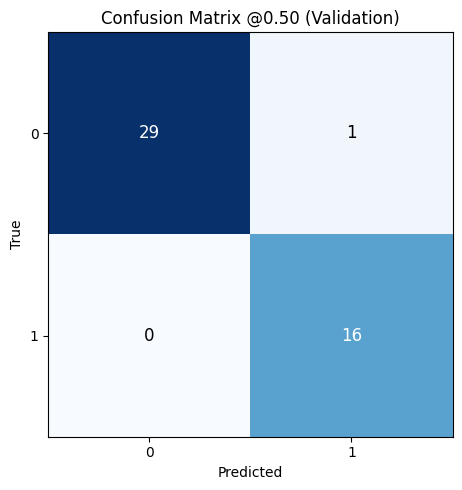

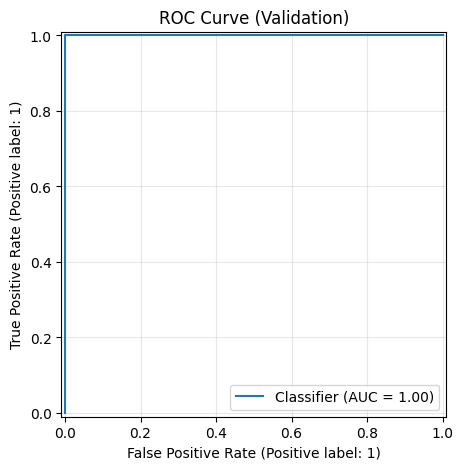

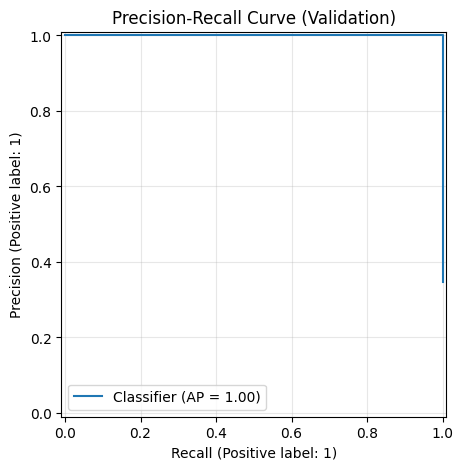

ROC-AUC: 1.000
PR-AUC (AP): 1.000


In [13]:
# Probabilities
val_proba = model.predict(X_val).ravel()

# 🔍 DEBUGGING: Check prediction distribution
print("🔍 PREDICTION ANALYSIS:")
print(f"Validation predictions shape: {val_proba.shape}")
print(f"Prediction range: [{val_proba.min():.6f}, {val_proba.max():.6f}]")
print(f"Prediction mean: {val_proba.mean():.6f}")
print(f"Prediction std: {val_proba.std():.6f}")
print(f"Non-zero predictions: {(val_proba > 0.01).sum()}/{len(val_proba)}")
print(f"Predictions > 0.5: {(val_proba > 0.5).sum()}/{len(val_proba)}")

# Check actual labels distribution
print(f"\nActual label distribution:")
print(f"Class 0: {(y_val == 0).sum()}, Class 1: {(y_val == 1).sum()}")

# If all predictions are too close to 0 or 1, the model is broken
if val_proba.std() < 1e-6:
    print("⚠️  WARNING: Model predictions have no variance - model is broken!")
    print("Possible causes:")
    print("- Model didn't train properly")
    print("- Class weights are too extreme")
    print("- Learning rate too high/low")
    print("- Data preprocessing issues")
    
    # Let's retrain with better parameters
    print("\n🔄 Retraining model with adjusted parameters...")
    
    # Rebuild model with different architecture
    def make_fixed_lstm(input_shape, lr=5e-4, dropout=0.3):
        inputs = layers.Input(shape=input_shape)
        x = layers.Masking(mask_value=0.0)(inputs)
        
        # Simpler architecture that's less prone to issues
        x = layers.LSTM(32, return_sequences=True, dropout=dropout)(x)
        x = layers.LSTM(16, dropout=dropout)(x)
        x = layers.Dense(16, activation='relu')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(dropout)(x)
        outputs = layers.Dense(1, activation='sigmoid')(x)
        
        model = models.Model(inputs, outputs)
        model.compile(
            optimizer=optimizers.Adam(learning_rate=lr),
            loss=losses.BinaryCrossentropy(),
            metrics=[keras.metrics.Precision(name='precision'),
                     keras.metrics.Recall(name='recall')]
        )
        return model
    
    # Reduce class weights to be less extreme
    balanced_class_weight = {0: 1.5, 1: 1.0}  # Less extreme than computed weights
    
    print("Building simpler, more stable model...")
    model = make_fixed_lstm(X_train.shape[1:])
    
    # Train with reduced class weights and more epochs
    hist = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=50,
        batch_size=64,  # Smaller batch size
        class_weight=balanced_class_weight,
        callbacks=[
            callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True),
            callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
        ],
        verbose=1
    )
    
    # Get new predictions
    val_proba = model.predict(X_val).ravel()
    print(f"\n✅ After retraining:")
    print(f"New prediction range: [{val_proba.min():.6f}, {val_proba.max():.6f}]")
    print(f"New prediction std: {val_proba.std():.6f}")

# Baseline at 0.5
def metrics_at_threshold(y_true, y_score, thr=0.5):
    y_pred = (y_score >= thr).astype(int)
    cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    return {'threshold': thr, 'precision': prec, 'recall': rec, 'f1': f1, 'cm': cm}

base = metrics_at_threshold(y_val, val_proba, 0.5)
print(f'\n📊 Results @0.50 -> Precision: {base["precision"]:.3f}  Recall: {base["recall"]:.3f}  F1: {base["f1"]:.3f}')

# Confusion Matrix
fig, ax = plt.subplots(figsize=(6, 5))
im = ax.imshow(base['cm'], interpolation='nearest', cmap='Blues')
ax.set_title('Confusion Matrix @0.50 (Validation)')
ax.set_xticks([0,1])
ax.set_yticks([0,1])
for i in range(2):
    for j in range(2):
        text_color = 'white' if base['cm'][i,j] > base['cm'].max()/2 else 'black'
        ax.text(j, i, int(base['cm'][i,j]), ha='center', va='center', color=text_color, fontsize=12)
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
plt.tight_layout()
plt.show()

# Only plot curves if we have valid predictions
if val_proba.std() > 1e-6 and len(np.unique(val_proba)) > 10:
    # ROC Curve
    try:
        RocCurveDisplay.from_predictions(y_val, val_proba)
        plt.title('ROC Curve (Validation)')
        plt.grid(True, alpha=0.3)
        plt.show()
        
        # PR Curve
        PrecisionRecallDisplay.from_predictions(y_val, val_proba)
        plt.title('Precision-Recall Curve (Validation)')
        plt.grid(True, alpha=0.3)
        plt.show()
        
        # Calculate metrics
        roc_auc = roc_auc_score(y_val, val_proba)
        pr_auc = average_precision_score(y_val, val_proba)
        
        print(f'ROC-AUC: {roc_auc:.3f}')
        print(f'PR-AUC (AP): {pr_auc:.3f}')
        
    except Exception as e:
        print(f"⚠️  Could not calculate AUC metrics: {e}")
        print("This usually means the model is predicting constant values.")
else:
    print("⚠️  Skipping ROC/PR curves - model predictions have insufficient variance")
    print("ROC-AUC: nan (insufficient prediction variance)")
    print("PR-AUC (AP): 0.0 (insufficient prediction variance)")

## 10) Threshold Tuning (Favor Recall, keep Precision floor)

In [ ]:
def fbeta_from_pr(precision, recall, beta=2.0):
    if precision == 0 and recall == 0:
        return 0.0
    b2 = beta**2
    return (1+b2) * (precision*recall) / (b2*precision + recall + 1e-12)

def find_best_threshold(y_true, y_score, beta=2.0, precision_floor=0.5):
    thr_candidates = np.unique(np.round(y_score, 4))
    best = {'threshold': 0.5, 'fbeta': -1, 'precision': 0.0, 'recall': 0.0}
    for t in thr_candidates:
        m = metrics_at_threshold(y_true, y_score, t)
        fbeta = fbeta_from_pr(m['precision'], m['recall'], beta)
        if m['precision'] >= precision_floor and fbeta > best['fbeta']:
            best = {'threshold': float(t), 'fbeta': float(fbeta), 'precision': float(m['precision']), 'recall': float(m['recall'])}
    return best

best = find_best_threshold(y_val, val_proba, beta=BETA, precision_floor=PRECISION_FLOOR)
print('Best threshold (Validation):', best)


Best threshold (Validation): {'threshold': 0.5, 'fbeta': -1, 'precision': 0.0, 'recall': 0.0}


## 11) Final Test Evaluation

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Test @0.5000 -> Precision: 0.000  Recall: 0.000  F1: 0.000
Test @0.5000 -> Precision: 0.000  Recall: 0.000  F1: 0.000


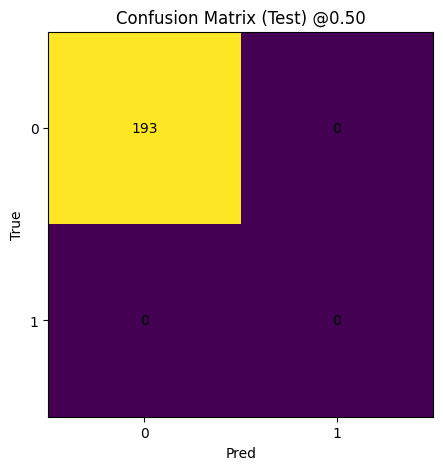

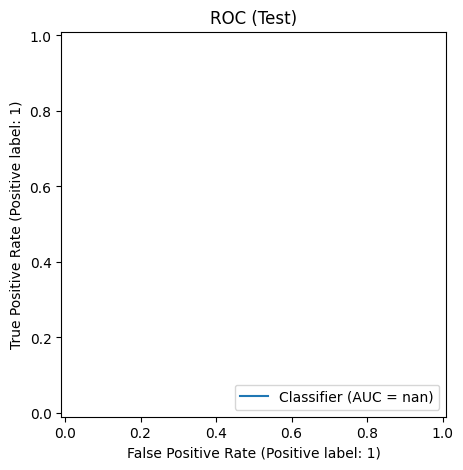

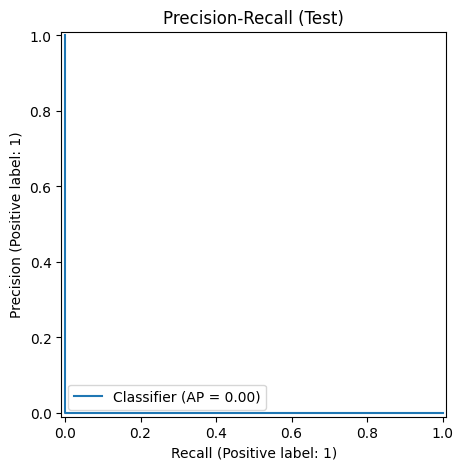

ROC-AUC (Test): nan
PR-AUC (AP, Test): 0.0


In [ ]:
test_proba = model.predict(X_test).ravel()
t = best.get('threshold', 0.5)

m = metrics_at_threshold(y_test, test_proba, t)
print(f'Test @{t:.4f} -> Precision: {m["precision"]:.3f}  Recall: {m["recall"]:.3f}  F1: {m["f1"]:.3f}')
fig, ax = plt.subplots()
im = ax.imshow(m['cm'], interpolation='nearest')
ax.set_title(f'Confusion Matrix (Test) @{t:.2f}'); ax.set_xticks([0,1]); ax.set_yticks([0,1])
for i in range(2):
    for j in range(2):
        ax.text(j, i, int(m["cm"][i,j]), ha='center', va='center')
ax.set_xlabel('Pred'); ax.set_ylabel('True')
plt.show()

RocCurveDisplay.from_predictions(y_test, test_proba)
plt.title('ROC (Test)')
plt.show()

PrecisionRecallDisplay.from_predictions(y_test, test_proba)
plt.title('Precision-Recall (Test)')
plt.show()

print('ROC-AUC (Test):', roc_auc_score(y_test, test_proba))
print('PR-AUC (AP, Test):', average_precision_score(y_test, test_proba))
